# Lets place this notebook in the root directory

In [5]:
import os
path = %pwd
if path.split(os.sep)[-1] == 'notebooks':
    %cd ..

/mnt/c/Users/Mustapha/Documents/competitions/klee_project_audio


Lets also refresh all our dependecies in run time

In [6]:
%reload_ext autoreload
%autoreload 2

load environment variables, if they exist

In [7]:
from dotenv import load_dotenv

load_dotenv(".env_consts")

True

# Imports

In [8]:
# -------------------------------- torch stuff ------------------------------- #
import torch

# ----------------------------------- other ---------------------------------- #
from tqdm import tqdm
import wandb

# ---------------------------------- Custom ---------------------------------- #
from src.load_dataset_fft_aug import get_splitter_dataloaders_fft

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Get data

In [323]:
F16 = torch.float16
F32 = torch.float32
F64 = torch.float64
FTYPE = F32
TRAIN_SPLIT = float(os.getenv('KLEE_TRAIN_SPLIT', 0.8))
BATCH_SIZE = int(os.getenv('KLEE_BATCH_SIZE', 64))
kwargs = {
        "BATCH_SIZE": BATCH_SIZE,
        "TRAIN_SPLIT": TRAIN_SPLIT,
        "FTYPE": FTYPE,
        "fft_nperseg": 400,
        "fft_noverlap": 240,
        "fft_window_type": "tukey",
        "fft_in_db": False,
        }

print("kwargs : ",kwargs)
train_loader, val_loader, data = get_splitter_dataloaders_fft(**kwargs)

kwargs :  {'BATCH_SIZE': 8, 'TRAIN_SPLIT': 0.8, 'FTYPE': torch.float32, 'fft_nperseg': 400, 'fft_noverlap': 240, 'fft_window_type': 'tukey', 'fft_in_db': False}


Caching dataset: 100%|██████████| 2/2 [00:00<00:00, 80.50it/s]


### debug

tensor(823.7726)
target :  tensor([0, 0])


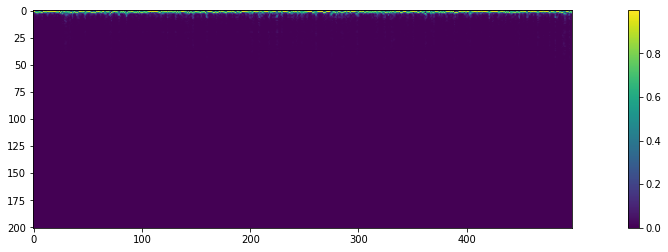

In [350]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy
data.add_noise = True
fft, target = data[0]
# print("norm", np.linalg.norm(fft, axis=0, keepdims=True))
# fft /= np.linalg.norm(fft, axis=1, keepdims=True) + 1e-8
print(fft.sum())
print("target : ",target)
plt.figure(figsize=(20, 4))
plt.imshow(fft[0])
plt.colorbar()
plt.show()

In [325]:
fft.squeeze(0).shape

torch.Size([201, 498])

In [326]:
import soundfile as sf
from utils.vscode_audio import Audio

time, clip = scipy.signal.istft(fft.squeeze(0).numpy(), fs=16000, nperseg=kwargs["fft_nperseg"], noverlap=kwargs["fft_noverlap"], window=kwargs["fft_window_type"])
print(len(time))
Audio(clip, 16000)

79520


[tensor([[[[5.6819e-03, 1.7686e-02, 8.3518e-03,  ..., 4.1985e-01,
           1.2656e-01, 1.0882e-03],
          [9.5128e-01, 9.8835e-01, 6.4121e-01,  ..., 2.0419e-01,
           7.9272e-01, 7.0685e-01],
          [3.0737e-01, 1.3498e-01, 7.6508e-01,  ..., 8.0774e-01,
           5.8685e-01, 7.0248e-01],
          ...,
          [9.2964e-09, 1.9489e-08, 3.1430e-08,  ..., 2.2211e-07,
           1.2899e-07, 3.1668e-08],
          [9.4967e-10, 6.4816e-09, 1.6304e-08,  ..., 5.7736e-07,
           6.7135e-08, 1.9768e-08],
          [5.4944e-10, 1.2724e-09, 6.3250e-09,  ..., 3.1606e-08,
           6.1896e-08, 2.3024e-08]]]]), tensor([[0, 0]])]
torch.Size([1, 1, 201, 498])


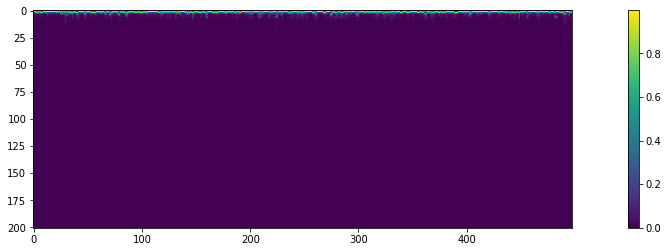

In [344]:
for d in train_loader:
    print(d)
    fft = d[0]
    plt.figure(figsize=(20, 4))
    print(fft.shape)
    plt.imshow(fft[0,0])
    plt.colorbar()
    plt.show()
    break

# Randomness propagates also with datalaloaders (y)

In [353]:
example, lab = train_loader.dataset[0]
example.shape  # (channel, frequency, time)

torch.Size([1, 201, 498])

# WandB

In [9]:
wandb.init(project="klee_project_audio", entity="mustapha")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mustapha (use `wandb login --relogin` to force relogin)


# Original model CRNN

### Create model

In [10]:
class PermuteForLSTM(torch.nn.Module):
    """
    Permute the input from (batch, channel, freq, time) to (batch, time, freq, channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.permute(0, 3, 2, 1)
    

class ReshapForLSTM(torch.nn.Module):
    """
    Reshape the input from (batch, time, freq, channel) to (batch, time, freq*channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(x.shape[0], x.shape[1], -1)

class SequentialLSTM(torch.nn.Module):
    """
    LSTMs in Pytorch, outputs a tuple (output, (h_n, c_n)), we only need output
    """
    def __init__(self, input_size=1280, hidden_size=40, num_layers=1, dropout=0):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
    def forward(self, x):
        x, _ = self.lstm(x)
        return x

In [11]:
# torch sequential
class Parameters():
    def __init__(self, parameters):
        self.__dict__.update(parameters)

def CRNN(p):
    return torch.nn.Sequential( #input size = 80000
        torch.nn.Conv2d(1, 64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 32, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=3),
        
        torch.nn.Conv2d(32, 128, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(128, 64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=3),
        
        torch.nn.Dropout(p.dropout),
        #permute 3 with 1
        PermuteForLSTM(),
        ReshapForLSTM(),
        SequentialLSTM(1280, 40), # 1280 = 20 freq *64 channels
        torch.nn.Tanh(),
        torch.nn.MaxPool1d(kernel_size=2, stride=2),
        
        
#         torch.nn.Conv2d(64, 64, kernel_size=5, stride=5),
#         torch.nn.ReLU(),
        
        
        torch.nn.Flatten(),
        torch.nn.Linear(53*20, 11), # Original contains 52*20, I don't know why !
        torch.nn.Softmax(dim=1)        
        
#         torch.nn.Linear(2560, 11), # Original contains 52*20, I don't know why !
#         torch.nn.Softmax(dim=1)
    )

params = Parameters({
    "dropout": 0.2,
})
model = CRNN(params)

In [12]:
model(example.unsqueeze(0)).shape

torch.Size([1, 11])

### Train model

In [13]:
LEARNING_RATE = 2e-3
EPOCHS = 700
MODEL_DROPOUT = params.dropout
EVAL_EACH = 10

wandb.config.update({
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "MODEL" : "RCNN",
    "MODEL_DROPOUT": MODEL_DROPOUT,
    "OPTIMIZER": "ADAM",
    # "batch_size": BATCH_SIZE,
    **kwargs
})

In [ ]:
mae = torch.nn.L1Loss()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to("cuda")

# wandb.watch(model, log_freq=1)
for epoch in range(EPOCHS):
    # -------------------------------- Train loop -------------------------------- #
    train_mean_loss = 0
    train_mean_count_loss = 0
    for d in tqdm(train_loader, "training loop"):
        audios = d[0].to("cuda")
        labels = d[1]
        # one hot encode labels
        count_labels = labels.sum(axis=1)
        one_hot_label = torch.eye(11)[count_labels].to("cuda")
        # forward pass
        predictions = model.forward(audios)
        # count loss
        count_loss_value = loss(predictions, one_hot_label)
        train_mean_count_loss += count_loss_value.item()
        #optimize
        optimizer.zero_grad()
        count_loss_value.backward()
        optimizer.step()
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    print("Train count Loss : {:.4f}".format(train_mean_count_loss/len(train_loader)))
    log = {
        "CrossEntropy_train_count_loss":train_mean_count_loss/len(train_loader),
        "epoch":epoch
        }
    # --------------------------------- Eval loop -------------------------------- #
    if (epoch+1)%EVAL_EACH == 0:
        val_mean_loss = 0
        val_mean_count_loss = 0
        model.eval()
        for d in tqdm(val_loader, "evaluation loop"):
            audios = d[0].to("cuda")
            labels = d[1]
            # one hot encode labels
            count_labels = labels.sum(axis=1)
            one_hot_label = torch.eye(11)[count_labels].to("cuda")
            # forward pass
            predictions = model.forward(audios)
            # count loss
            count_loss_value = mae(predictions, one_hot_label)
            val_mean_count_loss += count_loss_value.item()
        model.train()
        log["MAE_val_count_loss"] = val_mean_count_loss/len(val_loader)
        print("validation count Loss : {:.4f}".format(val_mean_count_loss/len(val_loader)))
        
    wandb.log(log)

training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 1/700
Train count Loss : 2.3959


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 2/700
Train count Loss : 2.2686


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 3/700
Train count Loss : 2.2113


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 4/700
Train count Loss : 2.1915


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]


Epoch 5/700
Train count Loss : 2.1559


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 6/700
Train count Loss : 2.1338


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 7/700
Train count Loss : 2.1036


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 8/700
Train count Loss : 2.0854


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 9/700
Train count Loss : 2.0702


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 10/700
Train count Loss : 2.0479


evaluation loop: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


validation count Loss : 0.1146


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 11/700
Train count Loss : 2.0359


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 12/700
Train count Loss : 2.0138


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]


Epoch 13/700
Train count Loss : 2.0093


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 14/700
Train count Loss : 1.9922


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 15/700
Train count Loss : 1.9737


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 16/700
Train count Loss : 1.9705


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 17/700
Train count Loss : 1.9618


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 18/700
Train count Loss : 1.9487


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 19/700
Train count Loss : 1.9434


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 20/700
Train count Loss : 1.9374


evaluation loop: 100%|██████████| 18/18 [00:02<00:00,  6.27it/s]


validation count Loss : 0.1106


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]


Epoch 21/700
Train count Loss : 1.9330


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 22/700
Train count Loss : 1.9184


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 23/700
Train count Loss : 1.9101


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 24/700
Train count Loss : 1.9070


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 25/700
Train count Loss : 1.8970


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 26/700
Train count Loss : 1.8921


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 27/700
Train count Loss : 1.8852


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 28/700
Train count Loss : 1.8836


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]


Epoch 29/700
Train count Loss : 1.8768


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 30/700
Train count Loss : 1.8754


evaluation loop: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]


validation count Loss : 0.1133


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 31/700
Train count Loss : 1.8717


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 32/700
Train count Loss : 1.8626


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 33/700
Train count Loss : 1.8559


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 34/700
Train count Loss : 1.8647


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 35/700
Train count Loss : 1.8520


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 36/700
Train count Loss : 1.8425


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]


Epoch 37/700
Train count Loss : 1.8504


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 38/700
Train count Loss : 1.8331


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 39/700
Train count Loss : 1.8267


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 40/700
Train count Loss : 1.8224


evaluation loop: 100%|██████████| 18/18 [00:02<00:00,  6.30it/s]


validation count Loss : 0.1099


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 41/700
Train count Loss : 1.8147


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 42/700
Train count Loss : 1.8161


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 43/700
Train count Loss : 1.8151


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 44/700
Train count Loss : 1.8073


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 45/700
Train count Loss : 1.8081


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 46/700
Train count Loss : 1.8018


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 47/700
Train count Loss : 1.7999


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 48/700
Train count Loss : 1.7950


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 49/700
Train count Loss : 1.7971


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 50/700
Train count Loss : 1.7841


evaluation loop: 100%|██████████| 18/18 [00:02<00:00,  6.24it/s]


validation count Loss : 0.1076


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 51/700
Train count Loss : 1.7834


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 52/700
Train count Loss : 1.7799


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 53/700
Train count Loss : 1.7791


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 54/700
Train count Loss : 1.7805


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 55/700
Train count Loss : 1.7733


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 56/700
Train count Loss : 1.7698


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 57/700
Train count Loss : 1.7653


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.97it/s]


Epoch 58/700
Train count Loss : 1.7666


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


Epoch 59/700
Train count Loss : 1.7610


training loop: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Epoch 60/700
Train count Loss : 1.7579


evaluation loop: 100%|██████████| 18/18 [00:02<00:00,  6.26it/s]


validation count Loss : 0.1068


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 61/700
Train count Loss : 1.7611


training loop: 100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


Epoch 62/700
Train count Loss : 1.7595


training loop:  32%|███▏      | 23/72 [00:11<00:25,  1.96it/s]

### Prediction

In [75]:
from time import time
val_mean_loss = 0
val_mean_count_loss = 0
model.eval()
tik = time()
for d in tqdm(val_loader, "evaluation loop"):
    audios = d[0].to("cuda")
    labels = d[1]
    # one hot encode labels
    count_labels = torch.tensor(labels.sum(axis=1), dtype=torch.float32).to("cuda")
    # forward pass
    predictions = torch.argmax(model.forward(audios), axis=1)
    # count loss
    count_loss_value = torch.abs(predictions - count_labels).mean()
    val_mean_count_loss += count_loss_value.item()
tok = time()
model.train()
log["MAE_val_count_loss_regression"] = val_mean_count_loss/len(val_loader)
log["eval_duration"] = tok-tik
print("validation count Loss : {:.4f}".format(val_mean_count_loss/len(val_loader)))

wandb.log(log)

evaluation loop:   0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_4676/4147267797.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  count_labels = torch.tensor(labels.sum(axis=1), dtype=torch.float32).to("cuda")
evaluation loop:   8%|▊         | 3/36 [00:00<00:06,  5.26it/s]

tensor([ 2.,  4.,  1.,  1.,  4.,  6.,  2.,  1.,  5., 10.,  9.,  9.,  6.,  3.,
        10.,  0.,  6.,  9.,  4.,  3.,  7.,  9., 10.,  3.,  4.,  6.,  5.,  2.,
         0.,  8.,  6.,  6.], device='cuda:0')
tensor([ 1,  4,  1,  1,  5,  6,  2,  1,  6, 10,  8, 10,  5,  3, 10,  0,  6, 10,
         4,  3,  8, 10, 10,  2,  4,  8,  6,  2,  0, 10,  6,  6],
       device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor([ 2.,  8.,  1.,  9.,  5.,  5.,  2.,  1.,  2.,  8.,  3.,  7.,  4.,  3.,
         9.,  4.,  2.,  0.,  8.,  3.,  2.,  6.,  6.,  5.,  7.,  1.,  8.,  4.,
         9.,  3., 10.,  0.], device='cuda:0')
tensor([ 2, 10,  1,  9,  4,  4,  1,  1,  2,  6,  3,  7,  4,  3,  9,  4,  2,  0,
         8,  3,  2,  4,  7,  5,  5,  1,  7,  6,  8,  2,  8,  0],
       device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor([ 6.,  0., 10.,  3.,  4.,  2.,  2.,  6.,  0.,  6.,  2.,  5.,  8.,  9.,
         6.,  3.,  1.,  9.,  0.,  9.,  9.,  2.,  8.,  2., 10.,  7.,  5.,  4.,
         3.,  1., 10.,  9.], device='c

evaluation loop:  14%|█▍        | 5/36 [00:00<00:04,  7.56it/s]

tensor([ 1.,  6.,  7.,  7.,  5.,  6.,  5.,  0.,  2.,  6.,  4.,  5.,  3.,  9.,
        10.,  4.,  1.,  5.,  3.,  9.,  4.,  5.,  0.,  6.,  0.,  3.,  0., 10.,
         9.,  3.,  9.,  0.], device='cuda:0')
tensor([ 1,  6,  9,  9,  5,  7,  5,  0,  2,  4,  3,  5,  3,  8, 10,  4,  2,  5,
         4,  9,  5,  8,  0, 10,  0,  2,  0, 10,  5,  2, 10,  0],
       device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor([3., 6., 6., 2., 1., 9., 3., 3., 6., 1., 2., 3., 5., 1., 9., 8., 4., 1.,
        2., 4., 7., 0., 9., 8., 8., 4., 6., 5., 1., 0., 0., 2.],
       device='cuda:0')
tensor([ 2,  6,  8,  2,  1, 10,  3,  4,  6,  2,  2,  2,  5,  2,  8,  7,  5,  1,
         2,  4,  5,  0,  8,  7, 10,  4,  6,  4,  2,  0,  0,  2],
       device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor([ 8.,  9.,  3.,  7.,  5.,  6.,  7.,  0.,  7.,  4.,  5.,  4.,  3.,  1.,
        10.,  6.,  4.,  0.,  1.,  0.,  7.,  9.,  8.,  7.,  5.,  7.,  3.,  3.,
         5.,  8.,  8.,  2.], device='cuda:0')
tensor([ 8, 10,  2,  8,  

evaluation loop:  25%|██▌       | 9/36 [00:01<00:02, 10.36it/s]

tensor([ 9.,  2.,  5.,  2.,  7.,  2.,  2.,  4.,  1.,  5., 10.,  5.,  8., 10.,
        10.,  8., 10.,  7.,  3.,  2.,  3.,  2.,  1.,  9.,  7.,  7.,  7.,  8.,
         2.,  0.,  1.,  8.], device='cuda:0')
tensor([ 9,  1,  7,  2,  5,  2,  1,  3,  1,  5,  8,  4,  8,  8,  8,  8, 10,  8,
         3,  2,  3,  1,  1,  9,  4,  9,  9, 10,  2,  0,  1,  7],
       device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor([ 5., 10.,  8.,  6., 10.,  3.,  9.,  8.,  9.,  0.,  9.,  4.,  9.,  3.,
         8.,  0.,  1.,  9.,  2.,  6., 10.,  2.,  4.,  3.,  6.,  4.,  3.,  4.,
         1.,  8.,  9.,  7.], device='cuda:0')
tensor([ 5,  8, 10,  7,  9,  4, 10, 10,  9,  0,  7,  4,  9,  3,  9,  0,  1, 10,
         2,  6,  8,  2,  3,  4,  8,  3,  2,  4,  1,  7, 10,  8],
       device='cuda:0')
tensor(0.7812, device='cuda:0')
tensor([ 8.,  3.,  9., 10.,  9.,  1.,  5.,  0.,  6.,  8.,  4.,  8.,  9.,  8.,
         5.,  2.,  9.,  9.,  9., 10.,  5.,  5.,  2.,  9.,  6.,  5.,  7.,  8.,
         1.,  1.,  4.,  5.], device='c

evaluation loop:  31%|███       | 11/36 [00:01<00:02, 11.19it/s]

tensor([ 1.,  4., 10.,  9.,  0.,  8.,  7.,  7.,  9.,  0.,  0.,  9.,  0.,  4.,
         5.,  1.,  5.,  7.,  2., 10.,  1.,  6.,  9.,  0.,  0.,  7.,  7.,  6.,
         4.,  2.,  0.,  8.], device='cuda:0')
tensor([ 1,  4,  9, 10,  0, 10,  9,  7, 10,  0,  0,  7,  0,  4,  5,  1,  5,  7,
         2, 10,  1,  5, 10,  0,  0,  7,  9,  7,  6,  1,  0,  9],
       device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor([ 3.,  6.,  4.,  6.,  6.,  2.,  5.,  8.,  2.,  8.,  1.,  9.,  2.,  6.,
         9.,  1.,  7., 10.,  9.,  2.,  8.,  3.,  7.,  0., 10.,  9.,  2.,  1.,
         6.,  6.,  0.,  9.], device='cuda:0')
tensor([ 3,  6,  4,  7,  6,  2,  5, 10,  2,  9,  1,  6,  3,  6, 10,  1,  5,  9,
        10,  1,  8,  4, 10,  0, 10,  7,  2,  1,  4,  6,  0, 10],
       device='cuda:0')
tensor(0.7188, device='cuda:0')
tensor([ 2., 10.,  2.,  2.,  4.,  8., 10., 10.,  6.,  9.,  3.,  8.,  5.,  7.,
         8.,  9.,  5.,  3.,  1.,  6.,  3., 10.,  5.,  0.,  3., 10.,  3.,  1.,
         6.,  9.,  4.,  0.], device='c

evaluation loop:  42%|████▏     | 15/36 [00:01<00:01, 12.20it/s]

tensor([ 1.,  2.,  6.,  9.,  8.,  3.,  2.,  1.,  2.,  9.,  7.,  8.,  6.,  7.,
         5., 10.,  4.,  7., 10.,  0.,  8.,  5.,  6.,  7.,  6.,  6.,  5.,  8.,
         2.,  5.,  4., 10.], device='cuda:0')
tensor([ 1,  2,  6,  8, 10,  2,  2,  2,  3,  9,  5,  9,  7,  8,  6, 10,  3,  8,
         9,  0,  9,  4,  5,  8,  6,  5,  6,  8,  2,  5,  4,  9],
       device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor([ 4., 10.,  2.,  2.,  5.,  7.,  6.,  1.,  6.,  1.,  6.,  3., 10.,  2.,
         3.,  7.,  5.,  4.,  1., 10.,  0., 10.,  6., 10.,  3.,  2.,  8.,  3.,
         2.,  6.,  5., 10.], device='cuda:0')
tensor([ 5,  6,  2,  2,  7,  9,  5,  1, 10,  1,  5,  4, 10,  2,  4,  7,  5,  5,
         1, 10,  0, 10,  9, 10,  2,  2,  6,  4,  2,  8,  6,  8],
       device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor([ 4.,  7.,  5.,  4., 10.,  5.,  5.,  8.,  9.,  4., 10.,  4., 10.,  3.,
         2.,  1.,  7.,  6.,  3.,  2.,  9.,  4.,  1.,  7.,  7.,  7.,  5.,  7.,
         6.,  8.,  5.,  3.], device='c

evaluation loop:  47%|████▋     | 17/36 [00:01<00:01, 12.50it/s]

tensor([ 2.,  6.,  8.,  9.,  8.,  5., 10.,  6.,  5.,  4., 10.,  0.,  9.,  1.,
         5., 10.,  7.,  2.,  8.,  2.,  2.,  6.,  5.,  2.,  9.,  9.,  9.,  1.,
         1.,  6.,  1.,  5.], device='cuda:0')
tensor([ 2,  8,  9, 10,  7,  5, 10,  6,  5,  4, 10,  0,  9,  1,  5, 10,  8,  2,
         9,  2,  2,  6,  5,  1, 10,  9,  9,  2,  0,  5,  1,  5],
       device='cuda:0')
tensor(0.3750, device='cuda:0')
tensor([ 7., 10.,  0.,  7.,  1.,  1.,  1.,  9.,  2.,  9.,  7.,  1.,  2.,  4.,
        10.,  9.,  2.,  4.,  9.,  6.,  6.,  8., 10.,  3.,  0.,  6.,  2.,  4.,
         8.,  1.,  7.,  4.], device='cuda:0')
tensor([ 7, 10,  0,  8,  1,  2,  1,  9,  2, 10,  8,  1,  2,  4, 10,  7,  2,  5,
         9,  5,  5,  6, 10,  3,  0,  5,  3,  5,  9,  2,  6,  5],
       device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor([ 1.,  5., 10.,  0.,  4.,  4., 10.,  8.,  1.,  0.,  9., 10.,  9.,  9.,
         4.,  7.,  8.,  8.,  4.,  9.,  4.,  0.,  8.,  2.,  2.,  2.,  6.,  3.,
         2.,  7.,  6.,  8.], device='c

evaluation loop:  58%|█████▊    | 21/36 [00:02<00:01, 12.85it/s]

tensor([ 6.,  1.,  5.,  5.,  1.,  6.,  0.,  1.,  3.,  9.,  6.,  6., 10.,  0.,
         8.,  7.,  7.,  4.,  3., 10.,  4.,  7., 10.,  9.,  8., 10.,  7.,  9.,
         5.,  6.,  4.,  2.], device='cuda:0')
tensor([ 6,  1,  5,  5,  1,  5,  0,  2,  4, 10,  8,  5, 10,  0,  8,  6,  5,  5,
         3, 10,  4,  6,  9,  9,  9, 10,  8,  8,  5,  5,  4,  2],
       device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor([ 2.,  7.,  5.,  8.,  3.,  0., 10.,  4.,  5.,  2.,  5., 10.,  4.,  5.,
         0.,  5.,  8.,  8.,  3.,  4.,  0.,  4.,  6., 10., 10.,  3.,  2.,  9.,
         1., 10.,  8., 10.], device='cuda:0')
tensor([ 2,  7,  6, 10,  3,  0, 10,  4,  6,  2,  5, 10,  4,  5,  8,  5, 10, 10,
         3,  4,  0,  5,  5,  7,  9,  4,  2,  8,  1, 10,  6, 10],
       device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor([ 4.,  1.,  7.,  8.,  7.,  3.,  8.,  4., 10.,  9.,  7.,  9.,  7.,  7.,
         9.,  2.,  0., 10.,  7.,  2.,  5.,  8.,  7.,  5., 10.,  2.,  6.,  3.,
         2.,  9.,  4.,  6.], device='c

evaluation loop:  64%|██████▍   | 23/36 [00:02<00:01, 12.92it/s]

tensor([ 1.,  3.,  6.,  8.,  8.,  6.,  8.,  7.,  4.,  6.,  7.,  1., 10.,  5.,
         7.,  2.,  1.,  7.,  8.,  4.,  5.,  6.,  5., 10.,  5.,  4.,  8.,  0.,
         4.,  1.,  0.,  1.], device='cuda:0')
tensor([ 1,  4,  8,  9,  7,  6,  6,  8,  3,  4,  7,  2, 10,  3,  8,  3,  1, 10,
         7,  3,  4,  6,  6,  8,  4,  5,  7,  0,  5,  1,  0,  1],
       device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor([10.,  6.,  5.,  3.,  7., 10.,  1.,  6.,  5.,  3.,  9.,  2.,  0., 10.,
         9.,  7., 10.,  7.,  2.,  6., 10.,  3.,  9.,  9.,  1.,  8.,  7.,  0.,
         4.,  4.,  0.,  3.], device='cuda:0')
tensor([ 9,  5,  6,  4,  7, 10,  1,  6,  4,  2, 10,  2,  0, 10,  9,  6, 10, 10,
         2,  5, 10,  2,  9,  9,  2, 10,  8,  0,  4,  4,  0,  4],
       device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor([10.,  4., 10.,  3.,  7.,  1.,  0.,  3.,  5.,  2.,  7.,  0.,  6., 10.,
         9.,  7.,  6.,  6.,  7.,  7.,  3.,  6.,  0.,  0., 10.,  5.,  9.,  2.,
         5.,  6.,  8.,  4.], device='c

evaluation loop:  75%|███████▌  | 27/36 [00:02<00:00, 13.02it/s]

tensor([10.,  6.,  0.,  4.,  0.,  8.,  3.,  4.,  2.,  3., 10.,  0.,  1.,  9.,
         0.,  0.,  6.,  9.,  8., 10.,  1.,  6.,  3.,  5.,  2., 10.,  3.,  2.,
         3.,  7.,  2., 10.], device='cuda:0')
tensor([10,  4,  0,  4,  0,  7,  3,  4,  2,  3,  9,  0,  1,  7,  0,  0,  7,  8,
        10,  8,  2,  7,  3,  5,  1, 10,  4,  3,  2,  7,  2,  9],
       device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor([ 9.,  7.,  5., 10.,  9.,  4.,  1.,  5.,  0.,  9.,  8.,  0.,  3.,  4.,
         7.,  2.,  2.,  6.,  0.,  9.,  4.,  2.,  2.,  0.,  9.,  6.,  6.,  5.,
         0.,  0.,  5.,  4.], device='cuda:0')
tensor([ 9,  9,  5, 10,  9,  4,  1,  5,  0,  8,  6,  0,  2,  4, 10,  2,  2,  4,
         0, 10,  4,  2,  1,  0,  9,  6,  7,  5,  0,  0,  6,  4],
       device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor([5., 0., 0., 7., 5., 3., 0., 4., 8., 8., 3., 3., 0., 5., 5., 3., 3., 6.,
        0., 8., 7., 8., 1., 3., 4., 6., 2., 7., 3., 2., 0., 3.],
       device='cuda:0')
tensor([ 5,  0,  0,  6,  

evaluation loop:  81%|████████  | 29/36 [00:02<00:00, 13.04it/s]

tensor([ 6.,  3.,  9.,  9., 10.,  0.,  7.,  7.,  1.,  0.,  7.,  4.,  4.,  5.,
         8.,  5.,  6.,  1., 10.,  5.,  6., 10., 10.,  6.,  0.,  3.,  5.,  2.,
         7.,  1.,  2.,  2.], device='cuda:0')
tensor([ 6,  4, 10,  9,  7,  0,  5,  7,  1,  0,  8,  4,  6,  4, 10,  5,  5,  1,
         9,  5,  7, 10,  7,  8,  0,  2,  4,  3,  6,  2,  2,  3],
       device='cuda:0')
tensor(0.8438, device='cuda:0')
tensor([ 3.,  6.,  4.,  6.,  3.,  1.,  6., 10.,  5.,  4.,  6.,  3.,  7., 10.,
         8.,  0.,  4.,  1.,  9.,  5.,  5.,  6.,  8.,  8.,  5.,  7.,  6.,  5.,
        10.,  2., 10.,  2.], device='cuda:0')
tensor([ 3,  8,  7,  7,  4,  2,  7, 10,  7,  4,  4,  4,  9, 10,  9,  0,  4,  1,
         9,  3,  4,  9, 10,  9,  4,  6,  5,  4, 10,  2, 10,  2],
       device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor([10.,  3.,  1., 10.,  7.,  8.,  9., 10.,  2., 10.,  3.,  1.,  2.,  8.,
         4., 10.,  5.,  3.,  5.,  4.,  3.,  9.,  8.,  5.,  1.,  1.,  3.,  3.,
         9.,  2.,  5.,  2.], device='c

evaluation loop:  92%|█████████▏| 33/36 [00:02<00:00, 13.06it/s]

tensor([ 5.,  5.,  9.,  5.,  7.,  3., 10.,  0.,  3.,  7.,  5.,  6.,  7.,  4.,
         1.,  2.,  5.,  7., 10.,  5.,  3.,  9.,  2.,  5.,  4.,  0.,  4.,  3.,
         7.,  7., 10., 10.], device='cuda:0')
tensor([ 5,  3, 10,  5,  6,  2, 10,  0,  2,  7,  6,  8,  8,  3,  1,  1,  6,  6,
        10,  6,  3,  9,  3,  6,  3,  0,  3,  3,  7, 10, 10,  8],
       device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor([10.,  0.,  9.,  0.,  0.,  9.,  2., 10.,  5.,  4., 10.,  5.,  3.,  3.,
         5.,  9.,  3.,  4.,  2.,  1.,  2.,  8.,  9.,  6.,  2., 10.,  9.,  3.,
         9.,  9.,  5., 10.], device='cuda:0')
tensor([10,  0,  8,  0,  0,  8,  3, 10,  4,  5,  9,  3,  2,  4,  7,  9,  2,  4,
         1,  2,  3, 10,  9,  9,  3, 10,  8,  3,  8,  9,  6,  9],
       device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor([10.,  1.,  6.,  1.,  6.,  2.,  0.,  7.,  2.,  3.,  6.,  6., 10.,  3.,
         5.,  7.,  9., 10.,  1.,  0.,  2.,  3.,  5.,  5.,  9.,  5.,  6.,  8.,
         0.,  0.,  2.,  2.], device='c

evaluation loop:  97%|█████████▋| 35/36 [00:03<00:00, 13.09it/s]

tensor([ 7.,  8.,  2.,  9.,  2.,  8.,  6.,  7.,  7.,  5.,  6.,  1.,  4.,  9.,
         0.,  5.,  7.,  9.,  9.,  1.,  4.,  3.,  8.,  9.,  4.,  1.,  5.,  2.,
         5., 10.,  2.,  3.], device='cuda:0')
tensor([ 7,  8,  4,  8,  2,  6,  8,  7,  7,  3,  4,  1,  2, 10,  0,  4,  8,  8,
         8,  1,  4,  4,  8, 10,  6,  2,  5,  3,  4,  9,  2,  3],
       device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor([ 1.,  4.,  5.,  5.,  5.,  1.,  7.,  6.,  8.,  3.,  6.,  6.,  7.,  8.,
        10.,  4.,  6.,  9.,  7.,  1.,  0.,  1.,  5.,  2.,  4.,  3.,  4.,  5.,
         9.,  0.,  9.,  2.], device='cuda:0')
tensor([ 1,  6,  5,  7,  5,  1,  8,  7,  7,  4,  7,  6, 10, 10, 10,  4,  6,  8,
         4,  1,  0,  1,  4,  2,  4,  3,  4,  4, 10,  0,  6,  2],
       device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor([ 2.,  2.,  1.,  6.,  4., 10., 10.,  2.,  8.,  9.,  2., 10.,  2.,  0.,
         2.,  4.,  1.,  0.,  1.,  0.,  2.,  1.,  5.,  0.], device='cuda:0')
tensor([ 3,  2,  1,  5,  4, 10, 10,  2, 

evaluation loop: 100%|██████████| 36/36 [00:03<00:00, 10.85it/s]

validation count Loss : 0.7072


In [78]:
# torch.save(model, "custom_models/CRNN_7072mae")